In [1]:
# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from scipy import stats
import statistics as st
from sklearn.model_selection import cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Метрики
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Misc
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('./Data/SpotifyFeatures.csv')
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [3]:
df = df.drop(['genre', 'artist_name', 'track_name', 'track_id', 'time_signature', 'valence', 'loudness', 'mode', 'acousticness', 'popularity', 'speechiness', 'energy', 'danceability'], axis=1)

In [4]:
df.head()

,duration_ms,instrumentalness,key,liveness,tempo
0,99373,0.000,C#,0.3460,166.969
1,137373,0.000,F#,0.1510,174.003
2,170267,0.000,C,0.1030,99.488
3,152427,0.000,C#,0.0985,171.758
4,82625,0.123,F,0.2020,140.576


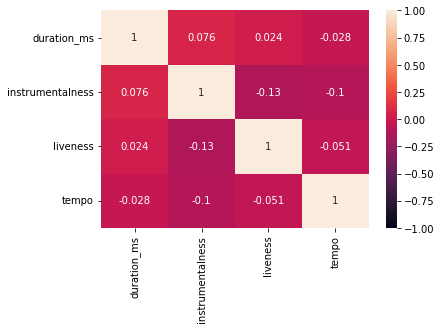

In [5]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

(array(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'],
      dtype=object), array([22671, 15526, 17661, 27583, 23201, 24077,  7566, 17390, 20279,
       15222, 26390, 15159], dtype=int64))


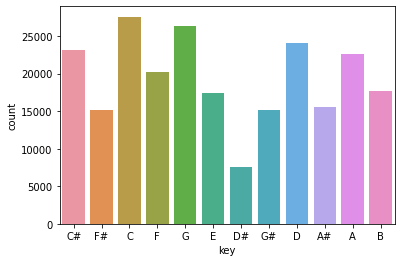

In [6]:
print(np.unique(df.key, return_counts=True))
sns.countplot(x='key', data=df);

In [7]:
df.head()

,duration_ms,instrumentalness,key,liveness,tempo
0,99373,0.000,C#,0.3460,166.969
1,137373,0.000,F#,0.1510,174.003
2,170267,0.000,C,0.1030,99.488
3,152427,0.000,C#,0.0985,171.758
4,82625,0.123,F,0.2020,140.576


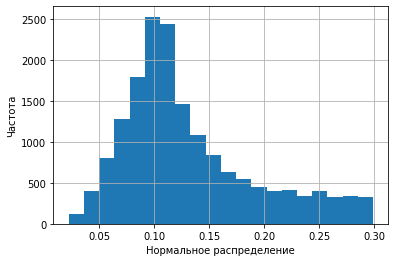

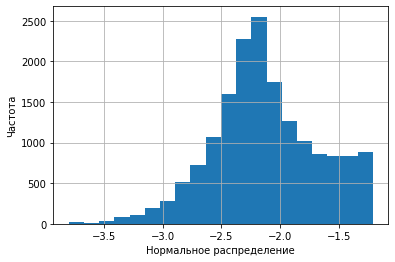

In [8]:
df = df.loc[(df['duration_ms'] > 120000) & (df['duration_ms'] < 410000)
            &(df['instrumentalness'] > 0) & (df['instrumentalness'] < 0.00001)
            &(df['liveness'] > 0.022) & (df['liveness'] < 0.3)
            &(df['tempo'] > 60) & (df['tempo'] < 200)]
temp = 'liveness'
pd.Series(df[temp]).hist(bins=20)
plt.xlabel('Нормальное распределение')
plt.ylabel('Частота')
plt.show()
pd.Series(np.log(df[temp])).hist(bins=20)
plt.xlabel('Нормальное распределение')
plt.ylabel('Частота')
plt.show()

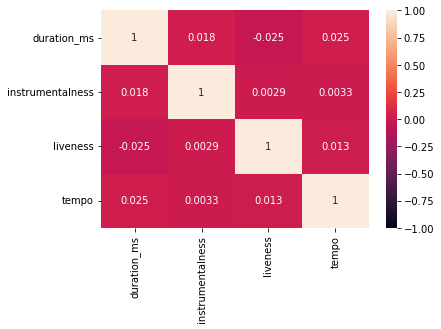

In [9]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);


In [10]:
df.count()

duration_ms         16897
instrumentalness    16897
key                 16897
liveness            16897
tempo               16897
dtype: int64

In [11]:
for col in df.columns:
    if col == 'key':
        continue
    print('{} - {}'.format(col, stats.normaltest(np.log(df[col]))))

duration_ms - NormaltestResult(statistic=2.868809726712482, pvalue=0.23825711737037855)
instrumentalness - NormaltestResult(statistic=15718.094012822254, pvalue=0.0)
liveness - NormaltestResult(statistic=7.042854805992794, pvalue=0.02955721498521788)
tempo - NormaltestResult(statistic=1466.6807446570792, pvalue=0.0)


In [12]:
for col in df.columns:
    if col == 'key':
        continue
    print('{} - {}'.format(col, stats.normaltest(df[col])))

duration_ms - NormaltestResult(statistic=1165.280186415539, pvalue=9.175348828914578e-254)
instrumentalness - NormaltestResult(statistic=1773.8593370021786, pvalue=0.0)
liveness - NormaltestResult(statistic=2015.5191547648137, pvalue=0.0)
tempo - NormaltestResult(statistic=1055.8514279122628, pvalue=5.306101752988979e-230)


In [13]:
new_df = df

new_df['duration_ms'] = np.log(new_df['duration_ms'])
new_df['liveness'] = np.log(new_df['liveness'])


In [14]:
X = new_df.drop(['key'], axis=1)
y = new_df['key']
y = np.squeeze(y)

print(f'Type X: {type(X)}, X shape: {X.shape}')
print(f'Type y: {type(y)}, y shape: {y.shape}')

Type X: <class 'pandas.core.frame.DataFrame'>, X shape: (16897, 4)
Type y: <class 'pandas.core.series.Series'>, y shape: (16897,)


In [15]:
forest_clf = RandomForestClassifier()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7,scoring = make_scorer(f1_score, average='weighted')).mean()
print(forest_acc_score)

0.5245400991509271


In [16]:
knn_clf = KNeighborsClassifier()
knn_acc_score = cross_val_score(knn_clf, X, y, cv=7,scoring = make_scorer(f1_score, average='weighted')).mean()
print(knn_acc_score)

C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with featu

0.31311461440277083


C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [17]:
svc_clf = SVC()
svc_acc_score = cross_val_score(svc_clf, X, y, cv=7,scoring = make_scorer(f1_score, average='weighted')).mean()
print(svc_acc_score)

0.041544874246114714


In [18]:
# Инициализируем алгоритмы с параметрами по-умолчанию

# Посчитаем метрику качества используя кросс-валидацию

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('Forest', forest_acc_score),
    ('SVC', svc_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. Forest: 0.5245400991509271
2. KNN: 0.31311461440277083
3. SVC: 0.041544874246114714
